# TFM – Predicción de dirección diaria del S&P 500

_Notebook listo para ejecutar sobre `Processed_S&P.csv`_

## 0. Setup

In [1]:


CSV_PATH = "Processed_S&P.csv"  
RESULTS_DIR = "resultados_tfm"


In [2]:
pip install numpy pandas scikit-learn matplotlib joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\avall\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:


import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Dict, Any, Tuple
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
os.makedirs(RESULTS_DIR, exist_ok=True)


## 1. Carga y exploración

In [4]:

df = pd.read_csv(CSV_PATH)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.sort_values("Date").reset_index(drop=True)
df.shape, df.head(3)


((1984, 84),
         Date        Close    Volume       mom      mom1  mom2  mom3  ROC_5  \
 0 2009-12-31  1115.099976       NaN       NaN       NaN   NaN   NaN    NaN   
 1 2010-01-04  1132.989990  0.921723  0.016043       NaN   NaN   NaN    NaN   
 2 2010-01-05  1136.520020 -0.375903  0.003116  0.016043   NaN   NaN    NaN   
 
    ROC_10  ROC_15  ...   NZD  silver-F  RUSSELL-F  S&P-F   CHF  \
 0     NaN     NaN  ...  0.03      0.26      -1.08  -1.00 -0.11   
 1     NaN     NaN  ...  1.52      3.26       1.61   1.62 -0.57   
 2     NaN     NaN  ... -0.07      1.96      -0.20   0.31  0.43   
 
    Dollar index-F  Dollar index  wheat-F   XAG   XAU  
 0           -0.08         -0.06    -0.48  0.30  0.39  
 1           -0.59         -0.42     3.12  3.91  2.10  
 2            0.03          0.12    -0.90  1.42 -0.12  
 
 [3 rows x 84 columns])

In [5]:

# Distribución de nulos por columna (top 20)
nulls = df.isna().mean().sort_values(ascending=False).head(20)
nulls


CAD        0.243448
JPY        0.241431
CNY        0.241431
GBP        0.240927
SSEC       0.119960
EMA_200    0.100302
HSI        0.085685
KOSPI-F    0.039819
HSI-F      0.037802
FTSE       0.035786
GDAXI      0.033770
EMA_50     0.024698
FCHI       0.020161
ROC_20     0.010081
EMA_20     0.009577
ROC_15     0.007560
ROC_10     0.005040
EMA_10     0.004536
FTSE-F     0.003024
ROC_5      0.002520
dtype: float64

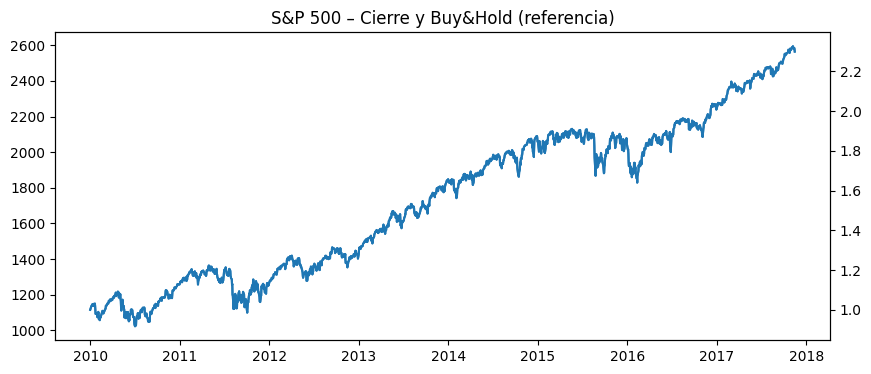

In [6]:

# Visualización simple de cierre y retorno acumulado buy&hold (si existe Close/Date)
if {"Date","Close"}.issubset(df.columns):
    serie = df.set_index("Date")["Close"]
    ret = serie.pct_change().fillna(0.0)
    ret_acum = (1+ret).cumprod()
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, label="Close")
    plt.twinx()
    plt.plot(ret_acum.index, ret_acum.values, label="Buy&Hold")
    plt.title("S&P 500 – Cierre y Buy&Hold (referencia)")
    plt.show()


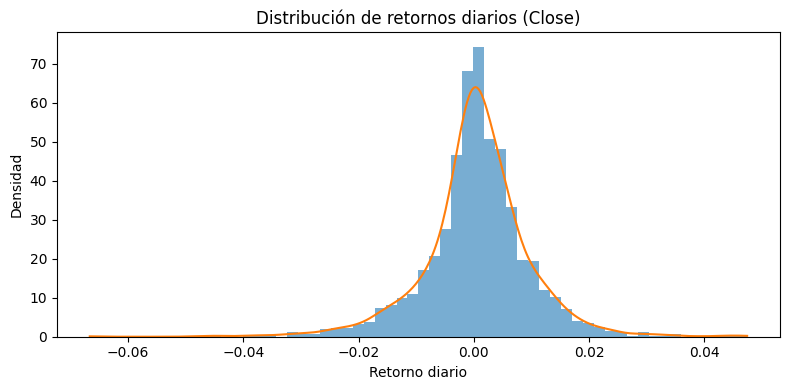

In [7]:
# Histograma de retornos diarios con densidad
import numpy as np
import matplotlib.pyplot as plt

if {"Date","Close"}.issubset(df.columns):
    serie = df.set_index("Date")["Close"].astype(float)
    ret = serie.pct_change().dropna()
    plt.figure(figsize=(8,4))
    # Histograma
    n, bins, patches = plt.hist(ret.values, bins=60, alpha=0.6, density=True)
    # Densidad kernel simple con numpy (aprox) si hay suficientes puntos
    try:
        from scipy.stats import gaussian_kde  # opcional
        kde = gaussian_kde(ret.values)
        xs = np.linspace(ret.min(), ret.max(), 400)
        plt.plot(xs, kde(xs))
    except Exception:
        pass
    plt.title("Distribución de retornos diarios (Close)")
    plt.xlabel("Retorno diario")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()
else:
    print("No se encuentran columnas Date/Close para calcular retornos.")


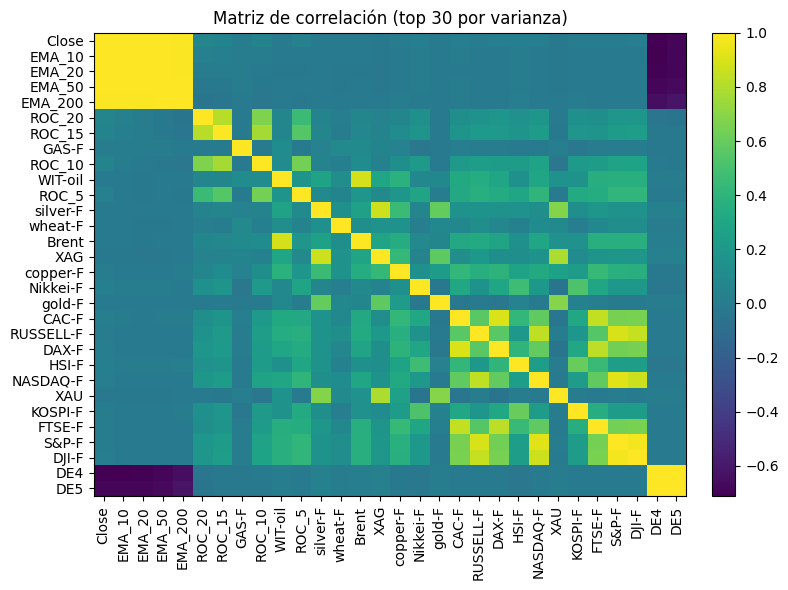

In [8]:
# Matriz de correlación (subset de variables numéricas con mayor varianza)
import numpy as np
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
subset = num_cols
if len(num_cols) > 30:
    var = df[num_cols].var().sort_values(ascending=False)
    subset = var.head(30).index.tolist()
corr = df[subset].corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, interpolation="nearest", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(subset)), subset, rotation=90)
plt.yticks(range(len(subset)), subset)
plt.title("Matriz de correlación (top 30 por varianza)")
plt.tight_layout()
plt.show()


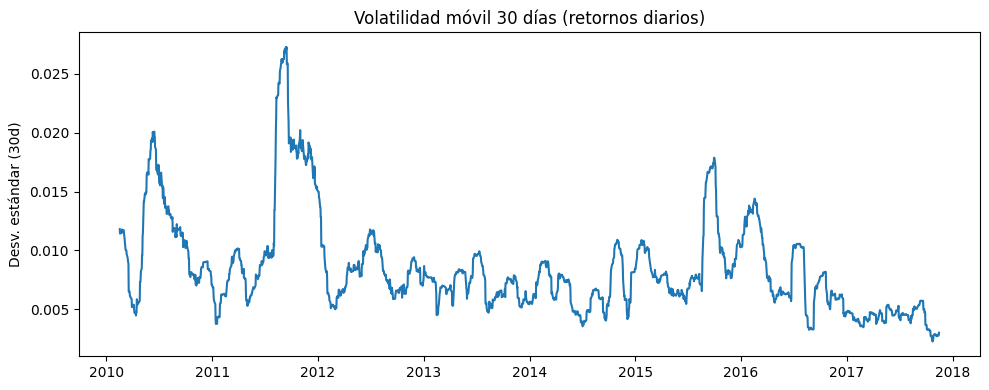

In [9]:
# Volatilidad móvil (desviación estándar a 30 días)
import numpy as np
import matplotlib.pyplot as plt

if {"Date","Close"}.issubset(df.columns):
    serie = df.set_index("Date")["Close"].astype(float)
    ret = serie.pct_change().dropna()
    vol_30 = ret.rolling(30).std()
    plt.figure(figsize=(10,4))
    plt.plot(vol_30.index, vol_30.values)
    plt.title("Volatilidad móvil 30 días (retornos diarios)")
    plt.ylabel("Desv. estándar (30d)")
    plt.tight_layout()
    plt.show()
else:
    print("No se encuentran columnas Date/Close para calcular volatilidad.")


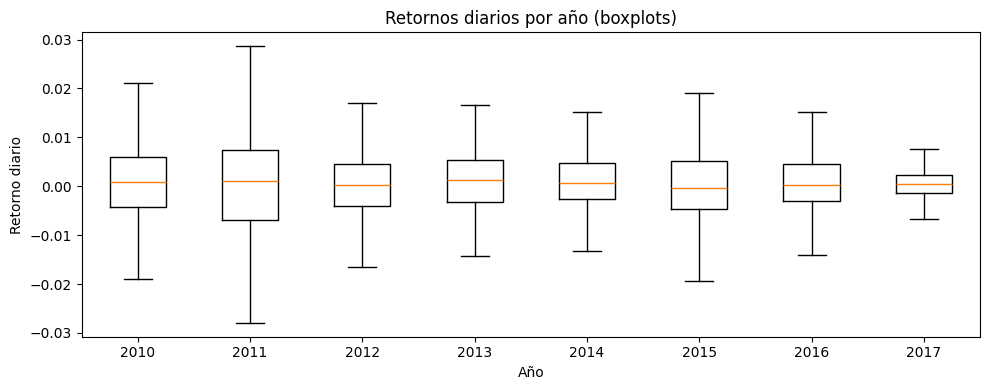

In [10]:
# Boxplots de retornos por año
import numpy as np
import matplotlib.pyplot as plt

if {"Date","Close"}.issubset(df.columns):
    serie = df.set_index("Date")["Close"].astype(float)
    ret = serie.pct_change().dropna()
    yearly = {}
    for year, vals in ret.groupby(ret.index.year):
        yearly[year] = vals.values
    years = sorted(yearly.keys())
    data = [yearly[y] for y in years]
    plt.figure(figsize=(10,4))
    plt.boxplot(data, labels=years, showfliers=False)
    plt.title("Retornos diarios por año (boxplots)")
    plt.xlabel("Año")
    plt.ylabel("Retorno diario")
    plt.tight_layout()
    plt.show()
else:
    print("No se encuentran columnas Date/Close para calcular retornos por año.")


## 2. Construcción del objetivo y selección de variables

In [11]:

# Target binario: 1 si el retorno t+1 > 0, 0 en caso contrario
if "Close" not in df.columns:
    raise ValueError("No se encuentra la columna 'Close' en el dataset.")
df["ret_diario"] = df["Close"].pct_change()
df["target"] = (df["ret_diario"].shift(-1) > 0).astype(int)
df = df.dropna(subset=["ret_diario"]).iloc[:-1]  # eliminar última fila sin target


In [12]:

# Selección de features numéricas (excluye target y columnas que puedan fugar info)
excluir = {"ret_diario", "target"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in excluir]
X = df[num_cols].copy()
y = df["target"].copy()
X.shape, y.shape, len(num_cols)


((1982, 82), (1982,), 82)

## 3. División temporal (train/test)

In [13]:

n = len(X)
cut = int(n*0.8)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]
X_train.shape, X_test.shape


((1585, 82), (397, 82))

## 4. Entrenamiento de modelos

In [14]:

def construir_modelos() -> Dict[str, Any]:
    modelos = {
        "Dummy(most_frequent)": Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
        ]),
        "LogReg": Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
        ]),
        "RandomForest": Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", RandomForestClassifier(
                n_estimators=200, max_depth=None, min_samples_leaf=2,
                class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
    }
    return modelos
modelos = construir_modelos()
list(modelos.keys())


['Dummy(most_frequent)', 'LogReg', 'RandomForest']

## 5. Evaluación en test (holdout)

In [15]:

def evaluar(y_true, y_pred, y_prob=None):
    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred))
    }
    out["roc_auc"] = float(roc_auc_score(y_true, y_prob)) if y_prob is not None else np.nan
    return out

resumen = []
mejor = {"nombre": None, "score": -np.inf, "modelo": None}

for nombre, pipe in modelos.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = None
    if hasattr(pipe, "predict_proba"):
        try:
            y_prob = pipe.predict_proba(X_test)[:,1]
        except Exception:
            y_prob = None
    met = evaluar(y_test, y_pred, y_prob)
    met["modelo"] = nombre
    resumen.append(met)
    criterio = met["roc_auc"] if not np.isnan(met["roc_auc"]) else met["balanced_accuracy"]
    if criterio > mejor["score"]:
        mejor = {"nombre": nombre, "score": criterio, "modelo": pipe}
pd.DataFrame(resumen).sort_values(["roc_auc","balanced_accuracy","accuracy"], ascending=False)


,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,modelo
2,0.460957,0.534884,0.105991,0.176923,0.497440,0.541603,RandomForest
1,0.549118,0.553073,0.912442,0.688696,0.511777,0.537148,LogReg
0,0.546599,0.546599,1.000000,0.706840,0.500000,0.500000,Dummy(most_frequent)


## 6. Importancias de variables (si aplica)

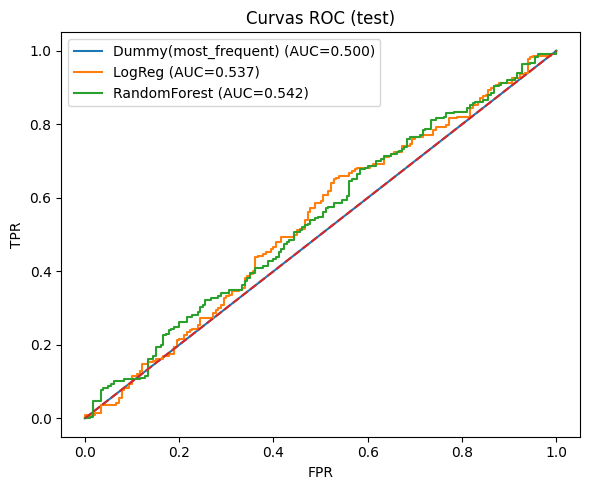

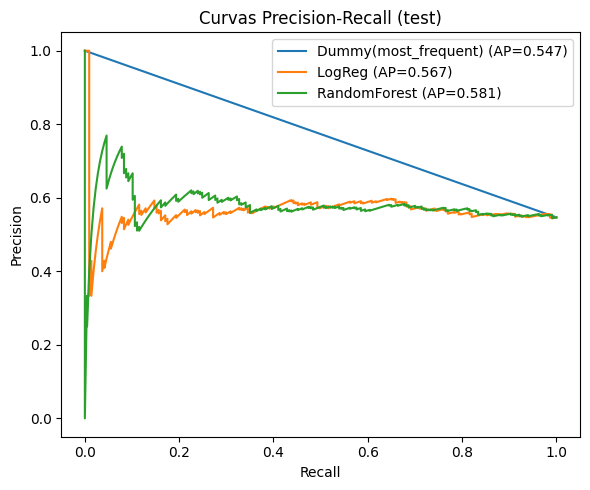

In [16]:
# Curvas ROC y Precision-Recall para los modelos comparados
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Reconstrucción rápida de modelos para obtener probabilidades de test
modelos = construir_modelos()

roc_curves = {}
pr_curves = {}
ap_scores = {}

for nombre, pipe in modelos.items():
    pipe.fit(X_train, y_train)
    if hasattr(pipe, "predict_proba"):
        try:
            y_prob = pipe.predict_proba(X_test)[:,1]
        except Exception:
            y_prob = None
    else:
        y_prob = None
    if y_prob is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[nombre] = (fpr, tpr, auc(fpr, tpr))
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    pr_curves[nombre] = (rec, prec)  # x=recall, y=precision
    ap_scores[nombre] = average_precision_score(y_test, y_prob)

# Plot ROC
plt.figure(figsize=(6,5))
for nombre, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC (test)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision-Recall
plt.figure(figsize=(6,5))
for nombre, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=f"{nombre} (AP={ap_scores[nombre]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall (test)")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:

importancias = None
try:
    est = mejor["modelo"].named_steps["clf"] if hasattr(mejor["modelo"], "named_steps") else mejor["modelo"]
    if hasattr(est, "feature_importances_"):
        arr = est.feature_importances_
        importancias = pd.DataFrame({"feature": X_test.columns, "importance": arr}).sort_values("importance", ascending=False).head(20)
except Exception:
    pass
importancias


,feature,importance
1,Volume,0.016518
27,AAPL,0.015715
56,CTB1Y,0.015256
31,JPM,0.015130
55,CTB6M,0.015063
34,XOM,0.015028
5,mom3,0.014840
41,SSEC,0.014743
9,ROC_20,0.014687
80,XAG,0.014668


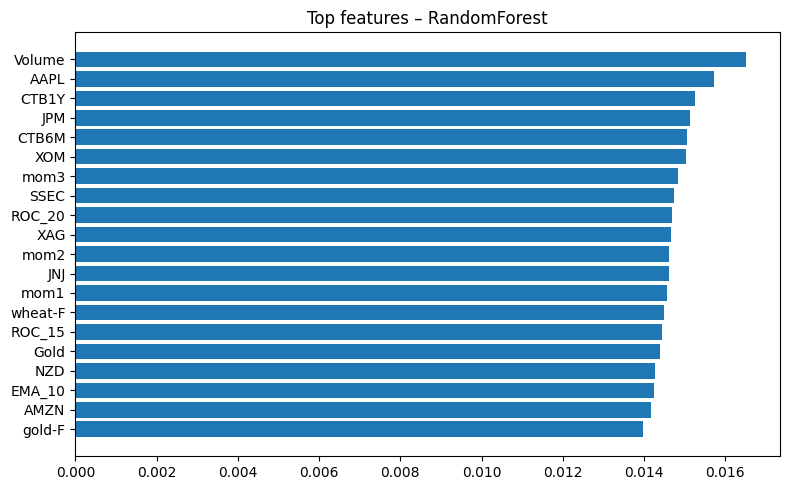

In [18]:

if importancias is not None and not importancias.empty:
    plt.figure(figsize=(8,5))
    plt.barh(importancias["feature"].iloc[::-1], importancias["importance"].iloc[::-1])
    plt.title(f"Top features – {mejor['nombre']}")
    plt.tight_layout()
    plt.show()


## 7. Guardar resultados y artefactos

In [19]:

# Guardar métricas
df_res = pd.DataFrame(resumen).sort_values(["roc_auc","balanced_accuracy","accuracy"], ascending=False)
df_res.to_csv(f"{RESULTS_DIR}/metrics_summary.csv", index=False)

# Guardar importancias (si hay)
if importancias is not None and not importancias.empty:
    importancias.to_csv(f"{RESULTS_DIR}/feature_importance.csv", index=False)

# Guardar modelo ganador
dump(mejor["modelo"], f"{RESULTS_DIR}/modelo_mejor.pkl")

# Resumen final
{
 "mejor_modelo": mejor["nombre"],
 "score_criterio": float(mejor["score"]),
 "paths": {
   "metrics": f"{RESULTS_DIR}/metrics_summary.csv",
   "importances": f"{RESULTS_DIR}/feature_importance.csv" if importancias is not None else None,
   "modelo": f"{RESULTS_DIR}/modelo_mejor.pkl"
 }
}


{'mejor_modelo': 'RandomForest',
 'score_criterio': 0.5416026625704045,
 'paths': {'metrics': 'resultados_tfm/metrics_summary.csv',
  'importances': 'resultados_tfm/feature_importance.csv',
  'modelo': 'resultados_tfm/modelo_mejor.pkl'}}

## 8. Predicción con nuevos datos (ejemplo)

In [20]:

# Ejemplo de uso: pasar una última fila de X_test al pipeline para obtener probabilidad
if len(X_test) > 0:
    muestra = X_test.tail(1)
    if hasattr(mejor["modelo"], "predict_proba"):
        prob_subida = float(mejor["modelo"].predict_proba(muestra)[:,1][0])
        {"prob_subida_t+1": prob_subida}
    else:
        {"prediccion_t+1": int(mejor["modelo"].predict(muestra)[0])}
